In [1]:
###############
### Imports ###
###############
import os
import csv
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

In [2]:
###########################
### Basic configuration ###
###########################

# Ignore warnings about deprecated features
warnings.simplefilter(action = "ignore")

In [3]:
############################################
#### Generation of the score dictionary  ### 
############################################

# Initialize the score dictionary
scores = {}
# Opening the score csv file
with open("scores.csv", mode = "r", encoding = "utf-8-sig") as file:
  # Reading the csv file
  scoreFile = csv.reader(file, delimiter = ";")
  # Save the contents of the CSV file
  for lines in scoreFile: 
    id = lines[0]
    score = lines[1]
    scores[id] = score

In [4]:
######################################################
### Generation of the locomotion matrix dictionary ###
######################################################

# Get the list of locomotion data files 
listLocomotionData = os.listdir("Locomotion")

# Initialize the data dictionary
data = {}

# Get the list of sensor names
sensor_names = pd.read_excel("Locomotion/" + listLocomotionData[0]).columns

# Iterate through the score dictionary
for key, value in scores.items(): 
  # Iterate through the list of locomotion data files 
  for locomotion in listLocomotionData: 
    if key in locomotion:
      df = pd.read_excel ("Locomotion/" + locomotion)
      df = df.fillna(0)
      df = df.to_numpy()
      data[key] = df

In [5]:
######################################
### Set dimensions of the matrices ###
######################################

# Initialize the number of rows and columns
n_rows = []
n_columns = 60

# Iterate through the data dictionary
for key, value in data.items(): 
  # Save the number of rows of the actual array
  n_rows.append(value.shape[0])
# Set the number of rows for all arrays with he minimal value
n_rows = max(n_rows)
# Print the number of rows and columns
print("COLUMNS:", n_columns, "ROWS:", n_rows)

COLUMNS: 60 ROWS: 623


In [6]:
#############################################################
### Generation of matrices and imputation of missing data ###
#############################################################

# Initialize the feature matrix and the class vector
X = []
y = []

# Iterate through the data dictionary
for key, value in data.items():
  # Build the features matrix
  if scores[key] == "2" or scores[key] == "2,5" or scores[key] == "3" or scores[key] == "3,5":
    x = []
    for i in range(n_columns):
      for j in range(n_rows):
        try: x.append(float(value[j][i]))
        except:x.append(float(0))
    x = np.array(x)
    X.append(x)
      
    # Save the classes
    if scores[key] == "2": y.append(0)
    elif scores[key] == "2,5":y.append(1)
    elif scores[key] == "3":y.append(2)
    elif scores[key] == "3,5" :y.append(3)
    else: pass

# Data scaling
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X)
X = minMaxScaler.transform(X)

# Transform the matrix avec vector to numpy array
X = np.array(X)
y = np.array(y)

In [7]:
#####################################
### Display the data informations ###
#####################################
print("Matrice:", X.shape)
print("Classes:", set(y))
print("Example of instance:", X[0])

Matrice: (74, 37380)
Classes: {0, 1, 2, 3}
Example of instance: [0. 0. 0. ... 0. 0. 0.]


In [8]:
#################################
### Perform data augmentation ###
#################################

# Initialize the feature matrix and the class vector for generated data
X_Generated = []
y_Generated = []

# Set the variables
variation_percentage = 1

# Iterate through the instances of X
for i, x in enumerate(X):
    
    # Set the number of instance to generate balanced dataset
    if y[i] == 0: n_generated_instances = 250
    if y[i] == 1: n_generated_instances = 167
    if y[i] == 2: n_generated_instances = 263
    if y[i] == 3: n_generated_instances = 1000
    
    # Iterate through the inumber of instances to generate
    for j in range(int(n_generated_instances / 20)):
        # Initialize the vector to save the new matrix
        x_Generated = []
        # Iterate through the row of the actual instance
        for value in x:
            # Generate random variation for the instance
            random_number = random.random()  * variation_percentage / 100
            # Generate boolen to add or remove the variation
            boolean = random.randint(0 , 1)
            # Save value adding variation
            if boolean == 0: x_Generated.append(value + value * random_number)
            # Save value removing variation
            else: x_Generated.append(value - value * random_number)
        # Covert the matrix vector to numpy matrix
        x_Generated = np.array(x_Generated)
        # Save the generated matrix
        X_Generated.append(x_Generated)
        # Save the associated classes
        y_Generated.append(y[i])

# Transform the matrix avec vector to numpy array
X_Generated = np.array(X_Generated)
y_Generated = np.array(y_Generated)

In [9]:
#####################################
### Display the data informations ###
#####################################
print("Matrice:", X_Generated.shape)
print("Classes:", set(y_Generated))
print("Example of instance:", X_Generated[0])

Matrice: (977, 37380)
Classes: {0, 1, 2, 3}
Example of instance: [0. 0. 0. ... 0. 0. 0.]


In [11]:
# Define the function to draw Scatter Plot
def generateScatterPlot(title, X_transformed, y_transformed, targets):
    # Define the figure and the axes
    fig = plt.figure(figsize=(15, 10))
    ax = Axes3D(fig)
    # List of colors
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    # Iterate through the targets
    for i, target in enumerate(targets):
        # Set the list of axis positions
        ax_x = []
        ax_y = []
        ax_z = []
        # Set the color
        color = colors[i]
        # Iterate through the data
        for i, d in enumerate(X_transformed):
            # If the sequence belongs to the target of interest
            if y_transformed[i] == target:
                # Save the values
                ax_x.append(X_transformed[i][0])
                ax_y.append(X_transformed[i][1])
                ax_z.append(X_transformed[i][2])
        # Add the current scatter plot to the figure
        ax.scatter(ax_x, ax_y, ax_z, c = color, label = target, alpha = 0.75, edgecolors = 'none')
    # Display the grid
    ax.grid(True)
    # Set the legend parameters
    ax.legend(loc = 2, prop = {'size': 10})
    # Set the tite
    plt.title(title)
    # Set axes labels
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    # Displqy the figure
    plt.show()

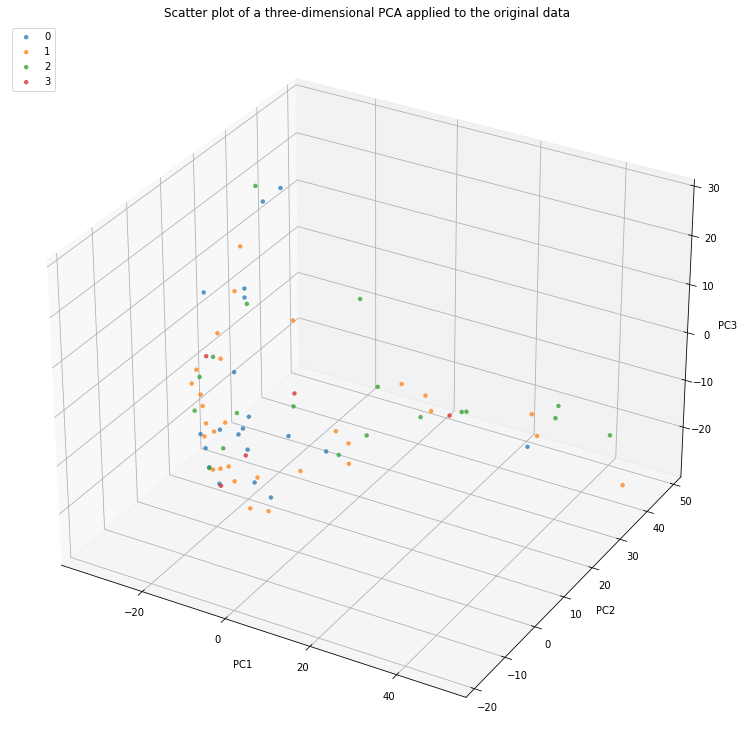

In [12]:
pca = PCA(n_components = 3)
X_pca =  pca.fit_transform(X)
generateScatterPlot(title= "Scatter plot of a three-dimensional PCA applied to the original data", X_transformed = X_pca, y_transformed= y, targets = set(y))

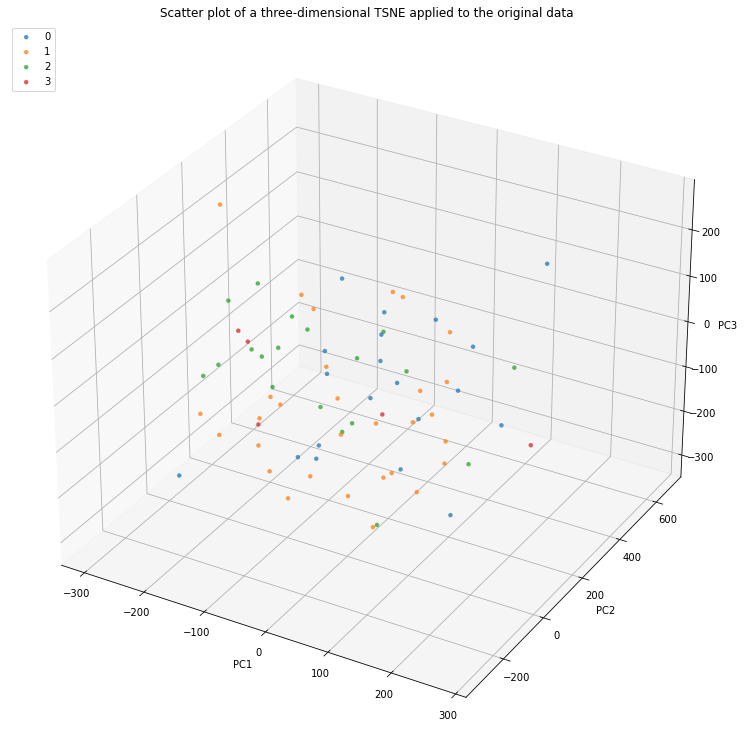

In [13]:
tsne = TSNE(n_components = 3, random_state = 0)
X_TSNE = tsne.fit_transform(X)
generateScatterPlot(title= "Scatter plot of a three-dimensional TSNE applied to the original data", X_transformed = X_TSNE, y_transformed= y, targets = set(y))

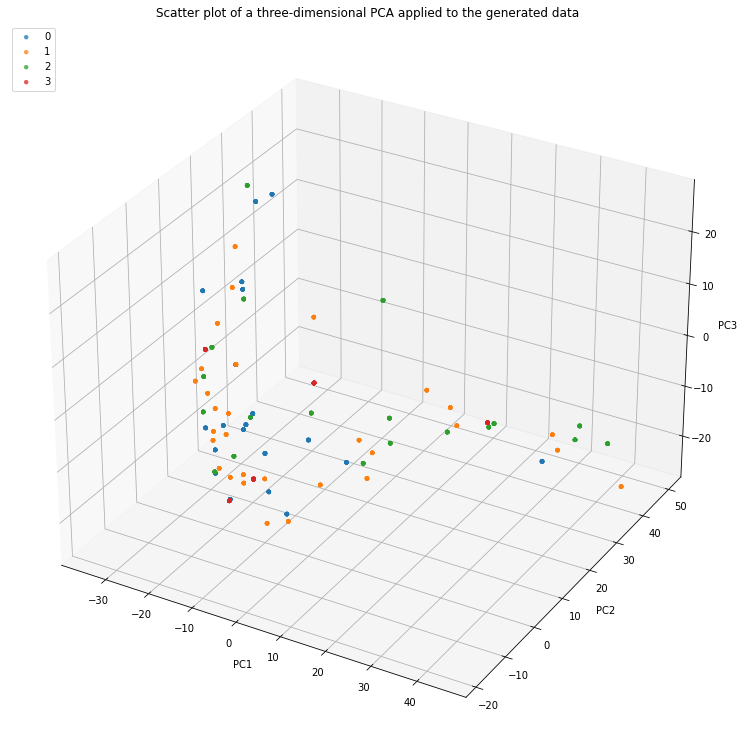

In [14]:
pca = PCA(n_components = 3)
X_pca =  pca.fit_transform(X_Generated)
generateScatterPlot(title= "Scatter plot of a three-dimensional PCA applied to the generated data", X_transformed = X_pca, y_transformed= y_Generated, targets = set(y))

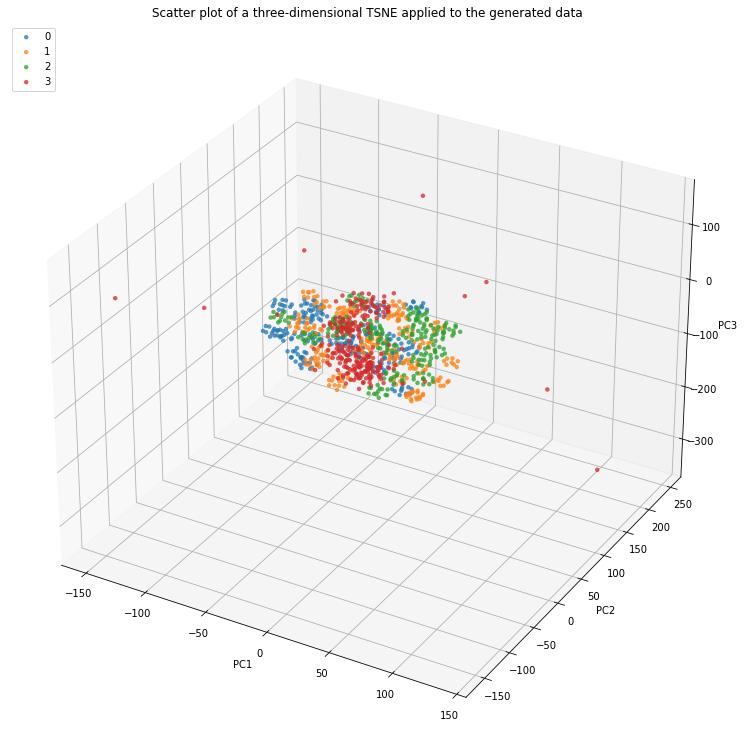

In [15]:
tsne = TSNE(n_components = 3, random_state = 0)
X_TSNE = tsne.fit_transform(X_Generated)
generateScatterPlot(title= "Scatter plot of a three-dimensional TSNE applied to the generated data", X_transformed = X_TSNE, y_transformed= y_Generated, targets = set(y))

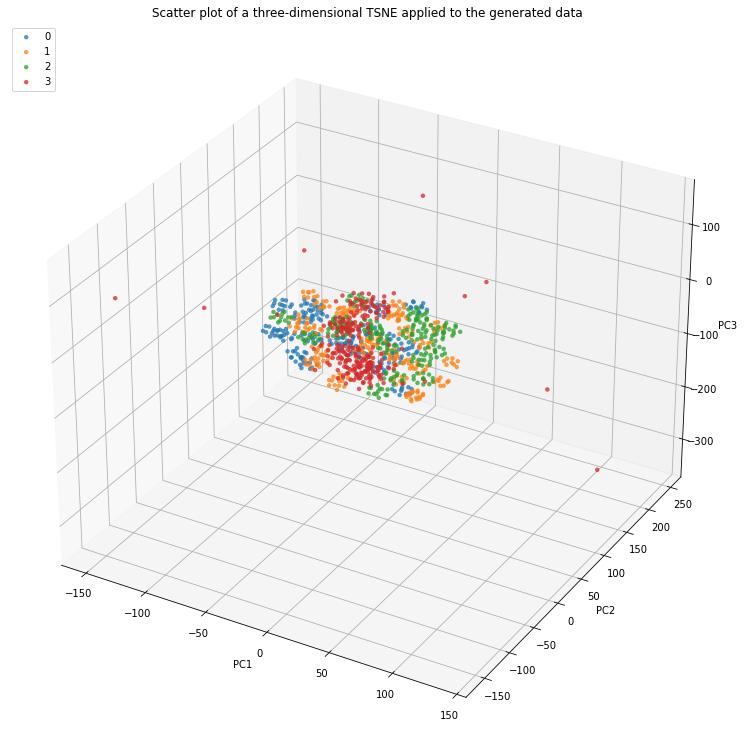

In [16]:
tsne = TSNE(n_components = 3, random_state = 0)
X_TSNE = tsne.fit_transform(X_Generated)
generateScatterPlot(title= "Scatter plot of a three-dimensional TSNE applied to the generated data", X_transformed = X_TSNE, y_transformed= y_Generated, targets = set(y))